#                              Prédiction de l'énergie de formation

## INITIAL DEFINITIONS

In [3]:
import pandas as pd
import scipy.io
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
from pymatgen.ext.matproj import MPRester
from matminer.data_retrieval.retrieve_MP import MPDataRetrieval
from pymatgen.io.cif import CifParser
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from ase.build import molecule
from dscribe.descriptors import CoulombMatrix
import warnings
from scipy.sparse import load_npz
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import math
from ase import Atoms
warnings.simplefilter('ignore')

rand_state = 42
tf.random.set_seed(rand_state)
np.random.seed(rand_state)

## Descripteur de matériaux

Le descripteur de matériaux qu'on va utiliser est la liste triés des valeurs propres de la matrice de Coulomb ce qui va nous permettre d'avoir l'invariance par translation et rotation

La matrice de Coulomb est donnée par : 

\begin{equation}
\begin{split}
M_{ij}^\mathrm{Coulomb}=\left\{
    \begin{matrix}
    0.5 Z_i^{2.4} & \text{for } i = j \\
        \frac{Z_i Z_j}{R_{ij}} & \text{for } i \neq j
    \end{matrix}
    \right.
\end{split}
\end{equation}

Après il suffit de diagonaliser la matrice et prendre les valeurs propres.

In [5]:
## liste qui contiendra la liste des matérieaux décrits par la bilbliothèque atoms
atoms = np.load("atoms.npy", allow_pickle=True)



In [6]:
### création de liste qui contiendra les matéreaux décrites par la liste triés des valeurs propres de la matrice de coulombe

Nel_max = max([len(at.get_positions()) for at in atoms])
cm = CoulombMatrix(n_atoms_max=Nel_max, flatten=False, permutation='eigenspectrum')
CMs = []
for atom in atoms:
    CMs.append(cm.create(atom))
CMs = np.array(CMs)


In [7]:
### importation de la liste des énergies qui corresponds à CMs

data = pd.read_csv('Materials_ene_real.csv', index_col=0)
energie = data['formation_energy_per_atom']
EF = np.array([])
for i in range(47743):
    EF = np.append(EF,energie[i])
print(EF)

[-0.15065287 -0.18149385  0.57219714 ... -1.77029296 -1.95287209
 -1.48799245]


In [8]:
### la taille des inputs
### taille des entrées

print("la taille de la liste des matéreaux est: " + str(len(CMs))+ "," + str(len(CMs[0])))
print("la taille de la liste des énergies est: " + str(len(EF)))


la taille de la liste des matéreaux est: 47743,432
la taille de la liste des énergies est: 47743


# Visualisation

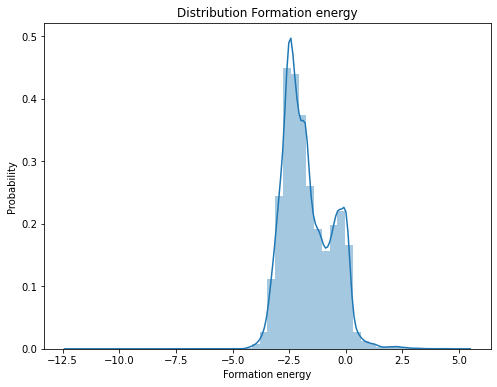

In [9]:
# Distribution de l'énergie

plt.figure(figsize=(8,6))
sns.distplot(EF)
plt.xlabel('Formation energy')
plt.ylabel('Probability')
plt.title('Distribution Formation energy')
plt.show()


# KRR un modèle naif 

In [15]:
## Je vais diviser mes données en 0.7/0.3 train/test

CMs_train, CMs_test, EF_train, EF_test = train_test_split(CMs, EF , test_size=0.3, random_state=rand_state)
alpha = 0.1
krr = KernelRidge(alpha)
krr.fit(CMs_train, EF_train)

KernelRidge(alpha=0.1)

Mean Abs Error (validation): 1.1103965998602645


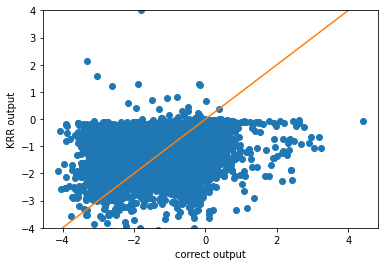

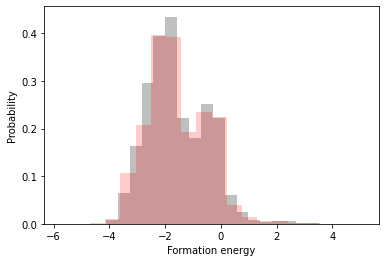

In [16]:
# la liste prédie en prenant comme entrée CM_test
predict = krr.predict(CMs_test) 

## erreur absolue entre les données prédies et les vraies valeurs
print("Mean Abs Error (validation): " + str((np.abs(predict-EF_test)).mean()))

# La vraie courbe
plt.plot(EF_test, predict, 'o')
plt.plot([np.min(EF_test),np.max(EF_test)], [np.min(EF_test),np.max(EF_test)], '-')
plt.xlabel('correct output')
plt.ylim(-4, 4)
plt.ylabel('KRR output')
plt.show()

# la courbe obtenue en utilisant le prédicteur KRR
plt.hist(EF_test, bins=20, density=True, alpha=0.5, facecolor='gray')
plt.hist(EF_train, bins=20, density=True, alpha=0.2, facecolor='red')
plt.xlabel("Formation energy")
plt.ylabel("Probability")
plt.show()


# CNN 1D

In [144]:
CMs_scaled = (CMs / 370.0).reshape((47743, 432, 1))
EF = EF.reshape((47743,))
EF_scaling_factor = 2000.
EF_scaled = EF / EF_scaling_factor

# now pull out 10% of the data for validation

x_2, x_val, y_2, y_val = train_test_split(CMs_scaled[:5000], EF[:5000],  test_size=.15, random_state=rand_state)

# the remaining 90% of the data will be used to build/test our model
x_train, x_dev, y_train, y_dev = train_test_split(x_2, y_2,  test_size=.18, random_state=rand_state)

In [145]:
model_1 = Sequential()
# our input is now a (276, 1) 1D Tensor
kernel_initializer='he_normal'

model_1.add(Conv1D(32, 10, activation='relu', kernel_initializer=kernel_initializer))
model_1.add(Conv1D(128, 7, activation='relu', kernel_initializer=kernel_initializer))
model_1.add(Conv1D(128, 5, activation='relu', kernel_initializer=kernel_initializer))
model_1.add(Conv1D(256, 3, activation='relu', kernel_initializer=kernel_initializer))
model_1.add(Flatten())
model_1.add(Dense(1, activation='linear'))

model_1.compile(optimizer= tf.keras.optimizers.Adam(.001) ,loss='mae', metrics=['mae'])



start = time.time()

estop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('cnn_1d.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, mindelta=1e-4, mode='min')

history_1 = model_1.fit(x_train, y_train,batch_size=4, epochs=20, callbacks=[estop, mcp_save, reduce_lr_loss], verbose=1, validation_data=(x_dev, y_dev))

model_1.summary()

end = time.time()
print('Execution time: ', end-start)
print("Epochs: ", len(history_1.history['val_loss']))
print('Train loss: ', EF*np.min(history_1.history['loss']))
print('Test loss: ', EF*np.min(history_1.history['val_loss']))
y_preds = model_1.predict(x_val)
print("Validation error: ", EF*mean_absolute_error(y_val, y_preds))


Epoch 1/20
872/872 [==============================] - 21s 23ms/step - loss: 0.9787 - mae: 0.9787 - val_loss: 0.7931 - val_mae: 0.7931 - lr: 0.0010
Epoch 2/20
872/872 [==============================] - 19s 21ms/step - loss: 0.6862 - mae: 0.6862 - val_loss: 0.5699 - val_mae: 0.5699 - lr: 0.0010
Epoch 3/20
872/872 [==============================] - 19s 22ms/step - loss: 0.4853 - mae: 0.4853 - val_loss: 0.4353 - val_mae: 0.4353 - lr: 0.0010
Epoch 4/20
872/872 [==============================] - 20s 23ms/step - loss: 0.4389 - mae: 0.4389 - val_loss: 0.4287 - val_mae: 0.4287 - lr: 0.0010
Epoch 5/20
872/872 [==============================] - 20s 23ms/step - loss: 0.4235 - mae: 0.4235 - val_loss: 0.3725 - val_mae: 0.3725 - lr: 0.0010
Epoch 6/20
872/872 [==============================] - ETA: 0s - loss: 0.4040 - mae: 0.4040
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
872/872 [==============================] - 19s 22ms/step - loss: 0.4040 - mae: 0.4040 - val_loss:

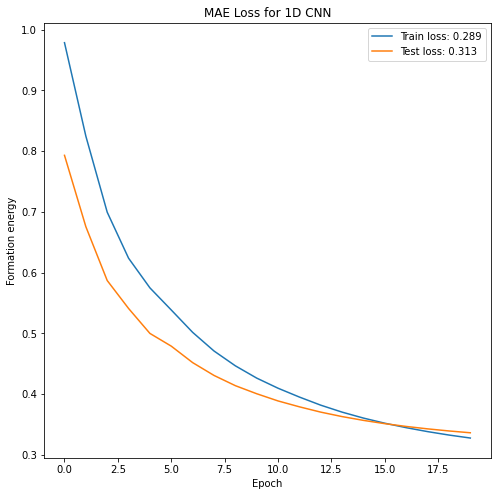

In [147]:
plt.figure(figsize=(8,8))
train_label = "Train loss: {}".format(np.round(np.min(history_1.history['loss']), 3))
test_label = "Test loss: {}".format(np.round(np.min(history_1.history['val_loss']), 3))
(pd.Series(history_1.history['loss']).ewm(alpha=.1).mean()).plot(label=train_label)
(pd.Series(history_1.history['val_loss']).ewm(alpha=.1).mean()).plot(label=test_label)
plt.legend()
plt.title('MAE Loss for 1D CNN')
plt.xlabel('Epoch')
plt.ylabel('Formation energy')
plt.show()

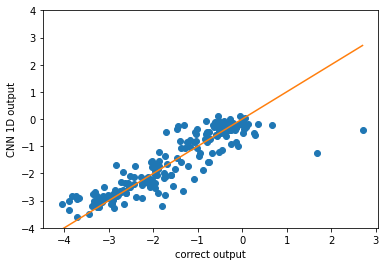

In [174]:
plt.plot(y_val[:200] , y_preds[:200], 'o')
plt.plot([np.min(EF_test),np.max(EF_test)], [np.min(EF_test),np.max(EF_test)], '-')
plt.xlabel('correct output')
plt.ylim(-4, 4)
plt.ylabel('CNN 1D output')
plt.show()

# CNN 2D

In [175]:
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras import optimizers

cm = CoulombMatrix(n_atoms_max=529, flatten=False, permutation='eigenspectrum')
CMs = []
for atom in atoms:
    CMs.append(cm.create(atom))
CMs = np.array(CMs)

CMs_scaled = CMs.reshape((47743, 23, 23, 1)) / 370.0





X_cm_train, X_cm_test, Y_train, y_test  = train_test_split(CMs_scaled, EF_scaled, test_size=0.15, random_state=rand_state)


x_train, x_cm_dev, y_train, y_dev = train_test_split(X_cm_train, Y_train,  test_size=.18, random_state=rand_state)


kernel_initializer='he_normal'
model_2 = Sequential()
model_2.add(Conv2D(32, kernel_size=(7,7), padding='same', activation='relu', kernel_initializer=kernel_initializer, input_shape=(23, 23, 1)))
model_2.add(Conv2D(64, kernel_size=(5,5), kernel_initializer=kernel_initializer, activation='relu'))
model_2.add(Conv2D(64, kernel_size=(3,3), kernel_initializer=kernel_initializer, activation='relu'))
model_2.add(Conv2D(64, kernel_size=(3,3), kernel_initializer=kernel_initializer, activation='relu'))
model_2.add(Conv2D(128, kernel_size=(3,3), kernel_initializer=kernel_initializer, activation='relu'))
model_2.add(Conv2D(128, kernel_size=(3,3), kernel_initializer=kernel_initializer, activation='relu'))
model_2.add(Flatten())
model_2.add(Dense(1, activation='linear'))
model_2.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(lr=.001), metrics=['mae'])

start = time.time()


estop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('cnn_2d.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, min_delta=1e-4, mode='min')

history_2 = model_2.fit(X_cm_train, Y_train, batch_size=4, epochs=20,  callbacks=[estop, mcp_save, reduce_lr_loss], verbose=1,validation_data=(x_cm_dev, y_dev))

end = time.time()
print(model_2.summary())

print('Execution time: ', end-start)
print("Epochs: ", len(history_2.history['val_loss']))
print('Train loss: ', EF_scaling_factor*np.min(history_2.history['loss']))
print('Test loss: ', EF_scaling_factor*np.min(history_2.history['val_loss']))


Epoch 1/20
1063/1063 [==============================] - 34s 31ms/step - loss: 0.0032 - mae: 0.0032 - val_loss: 5.5077e-04 - val_mae: 5.5077e-04 - lr: 0.0010
Epoch 2/20
1062/1063 [============================>.] - ETA: 0s - loss: 6.1248e-04 - mae: 6.1248e-04
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1063/1063 [==============================] - 31s 29ms/step - loss: 6.1237e-04 - mae: 6.1237e-04 - val_loss: 5.8158e-04 - val_mae: 5.8158e-04 - lr: 0.0010
Epoch 3/20
1061/1063 [============================>.] - ETA: 0s - loss: 5.4117e-04 - mae: 5.4117e-04
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
1063/1063 [==============================] - 31s 30ms/step - loss: 5.4183e-04 - mae: 5.4183e-04 - val_loss: 6.2169e-04 - val_mae: 6.2169e-04 - lr: 1.0000e-04
Epoch 4/20
1063/1063 [==============================] - ETA: 0s - loss: 5.2796e-04 - mae: 5.2796e-04
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-0

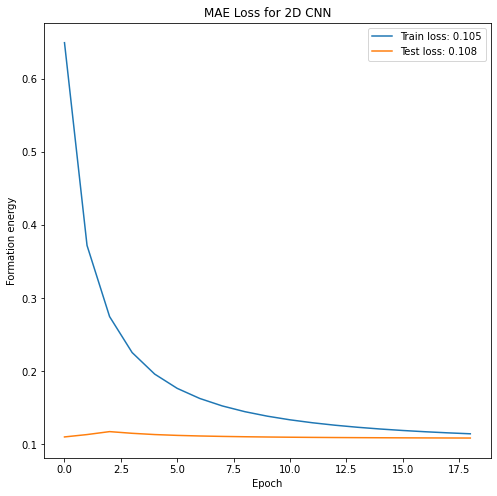

In [176]:
plt.figure(figsize=(8,8))
train_label = "Train loss: {}".format(np.round(np.min(history_2.history['loss'])*EF_scaling_factor, 3))
test_label = "Test loss: {}".format(np.round(np.min(history_2.history['val_loss'])*EF_scaling_factor, 3))
(pd.Series(history_2.history['loss']).ewm(alpha=.1).mean()*EF_scaling_factor).plot(label=train_label)
(pd.Series(history_2.history['val_loss']).ewm(alpha=.1).mean()*EF_scaling_factor).plot(label=test_label)
plt.legend()
plt.title('MAE Loss for 2D CNN')
plt.xlabel('Epoch')
plt.ylabel('Formation energy')
plt.show()

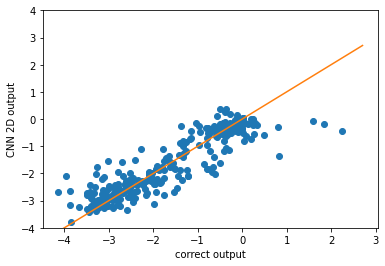

In [180]:
y_preds2 =  model_2.predict(X_cm_test)
plt.plot(y_test[:200] , y_preds[:200], 'o')
plt.plot([np.min(EF_test),np.max(EF_test)], [np.min(EF_test),np.max(EF_test)], '-')
plt.xlabel('correct output')
plt.ylim(-4, 4)
plt.ylabel('CNN 2D output')
plt.show()
